In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
IMAGE_SIZE = [224, 224]

train_path = 'E:\day-nigh\Train'

In [3]:
import os

num_skipped = 0
for folder_name in ("Day", "Night"):
    folder_path = os.path.join("E:\day-nigh\Train",folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [4]:
## Generate a Dataset

image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "E:\day-nigh\Train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "E:\day-nigh\Train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 946 files belonging to 2 classes.
Using 757 files for training.
Found 946 files belonging to 2 classes.
Using 189 files for validation.


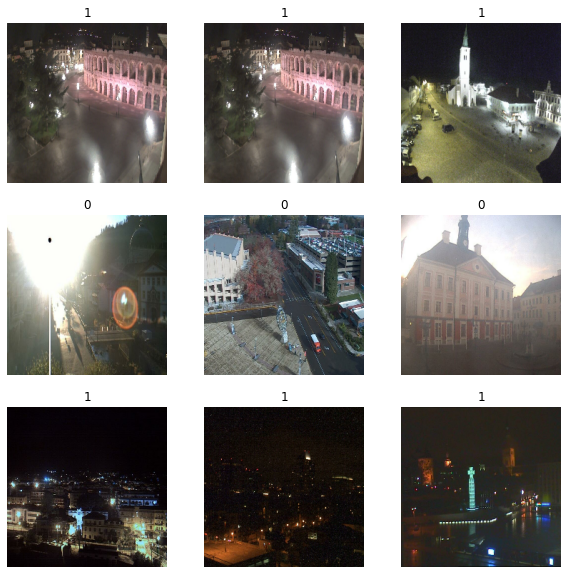

In [5]:
## Visualize the data

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
## image data augmentation

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [7]:
## preprocess the data
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [8]:
## Configure the dataset for performance

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [9]:
### Build a model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [10]:

## Train the model
## USE epochs =50 for better accuracy 
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/25
24/24 [==============================] - 674s 28s/step - loss: 0.1521 - accuracy: 0.9339 - val_loss: 0.6417 - val_accuracy: 0.6138
Epoch 2/25
24/24 [==============================] - 536s 22s/step - loss: 0.0706 - accuracy: 0.9868 - val_loss: 0.5845 - val_accuracy: 0.6138
Epoch 3/25
24/24 [==============================] - 543s 23s/step - loss: 0.0679 - accuracy: 0.9749 - val_loss: 0.5706 - val_accuracy: 0.6138
Epoch 4/25
24/24 [==============================] - 423s 18s/step - loss: 0.0374 - accuracy: 0.9855 - val_loss: 0.6139 - val_accuracy: 0.6138
Epoch 5/25
24/24 [==============================] - 425s 18s/step - loss: 0.0417 - accuracy: 0.9868 - val_loss: 0.5884 - val_accuracy: 0.6138
Epoch 6/25
24/24 [==============================] - 456s 19s/step - loss: 0.0415 - accuracy: 0.9894 - val_loss: 0.6575 - val_accuracy: 0.6138
Epoch 7/25
24/24 [==============================] - 428s 18s/step - loss: 0.0483 - accuracy: 0.9841 - val_loss: 0.6089 - val_accuracy: 0.6138
Epoch 

In [49]:

## Run inference on new data

img = keras.preprocessing.image.load_img(
    "E:\day-nigh\Train/Day/20151108_172534.jpg", target_size=image_size ## This photo for day
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Day and %.2f percent Night."
    % (100 * (1 - score), 100 * score)
)

This image is 99.81 percent Day and 0.19 percent Night.
